In [1]:
import pandas as pd
import numpy as np
import os, ast
os.chdir('..')
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
vdj = pd.read_csv('data/vdj_cleaned_subset_for_MI_IMGT_TCRs.csv', index_col=0)
vdj = vdj.loc[vdj['Epitope'] != 'KLGGALQAK'] # because too big - takes forever
epitope_counts = vdj['Epitope'].value_counts()
print(epitope_counts)
epitopes = vdj['Epitope'].unique().tolist()

GILGFVFTL     1894
AVFDRKSDAK    1699
RAKFKQLL      1200
IVTDFSVIK      704
RLRAEAQVK      412
ELAGIGILTV     380
NLVPMVATV      357
SSLENFRAYV     350
GLCTLVAML      345
YLQPRTFLL      333
HGIRNASFI      243
TTDPSFLGRY     242
LLWNGPMAV      235
CINGVCWTV      226
ASNENMETM      201
SSYRRPVGI      177
SPRWYFYYL      175
SSPPMFRV       133
LSLRNPILV      127
ATDALMTGF      125
LTDEMIAQY      124
KSKRTPMGF      103
Name: Epitope, dtype: int64


In [3]:
MI = pd.DataFrame()

for ep in epitopes + ['background', 'Tanno::A1::naive']:
    df = pd.read_csv('data/output/mutual_info/mutual_info_' + ep + '.csv')
    MI = pd.concat([MI, df])

In [4]:
MI = MI.set_index(['type', 'Unnamed: 0'])
MI.columns = [int(x) for x in MI.columns]
MI = MI.sort_index(axis=1)
# print(MI)

In [5]:
MI1 = MI.dropna(axis=0, how='all')
MI1 = MI1.replace(pd.NA, '[]')

In [6]:
# print(MI1)

In [7]:
for c in MI1.columns:
    MI1[c] = [ast.literal_eval(x) for x in MI1[c]]
    MI1[c] = [x if type(x) == list else [x]*10 for x in MI1[c]]
# print(MI1)

In [8]:
MI1 = MI1.reset_index(names = ['type','epitope'])
MI1['shuffle'] = ['shuffle' if 'shuffle' in x else 'real' for x in MI1['epitope']]
MI1['epitope'] = [x.split('_')[0] for x in MI1['epitope']]
# print(MI1)

In [9]:
MI2 = MI1.set_index(['epitope', 'shuffle', 'type']).apply(pd.Series).stack().explode()
MI2 = MI2.reset_index().rename(columns = {'level_3':'subsample', 0:'value'}).dropna(subset='value')

In [10]:
MI2['1/N'] = 1/MI2['subsample']

In [11]:
# ax = plt.subplot()
# sns.scatterplot(data = MI2, x = 'subsample', y='value', style='type', ax=ax, hue='epitope')
# plt.show()

In [12]:
# ax = plt.subplot()
# sns.scatterplot(data = MI2, x = '1/N', y='value', style='shuffle', ax=ax, hue='epitope', alpha = 0.5)
# ax.semilogx()
# plt.legend(bbox_to_anchor = [1.05,1])
# plt.show()

In [13]:
def fit_linear(mydf, title, ax):    
    single_vals = []
    def _fit(mydf1):
        df = mydf1.copy()
        df = df.dropna(subset=['value'])
        x = np.array(df['1/N'])
        myfit = np.polyfit(x, df['value'].astype('float64'), deg=1)
        p = np.poly1d(myfit)
        x_unique = np.linspace(0, max(x))
        y_unique = p(x_unique)
        # print(p, x_unique, y_unique)
        # print(x, df['value'].astype('float64'))
        assert p(0) == myfit[1]
        return(x_unique, y_unique, p(0))
    
    for j in ['real', 'shuffle']:
        if j == 'real':
            linestyle = '-'
            marker = 'o'
            s = 30
            col='r'
        else:
            linestyle = '-'
            marker = 'X'
            s = 30
            col='k'
        mydf0 = mydf.loc[mydf.shuffle == j]
        x_unique, y_unique, single_val = _fit(mydf0)    
        xy = pd.DataFrame([x_unique, y_unique], index = ['x', 'y']).T
        sns.scatterplot(data = mydf0, x = '1/N', y='value', ax=ax, alpha = 0.5, marker = marker, c=col, s = s, legend=None)
        sns.lineplot(data=xy, x='x', y='y', color = col, linestyle = linestyle, alpha = 0.5,  label = j, ax=ax)
        single_vals.append(single_val)
        # ax.scatter(0, single_val, marker = marker, color = col, s = 300, alpha = 0.5)
    ax.set_title(title)
    ax.set_xlim(0,0.041)
    # ax.set_yscale('log')
    # ax.set_xscale('log')

    return(single_vals)
    

(64200, 6)
['cdr3a-cdr3b', 'Va-Vb', 'Ja-Jb', 'Va-Ja', 'Vb-Jb', 'Va-Jb', 'Vb-Ja', 'Va-CDR3a', 'Vb-CDR3b', 'Ja-CDR3a', 'Jb-CDR3b', 'Va-CDR3b', 'Vb-CDR3a', 'Ja-CDR3b', 'Jb-CDR3a']
(64200, 6)
ASNENMETM


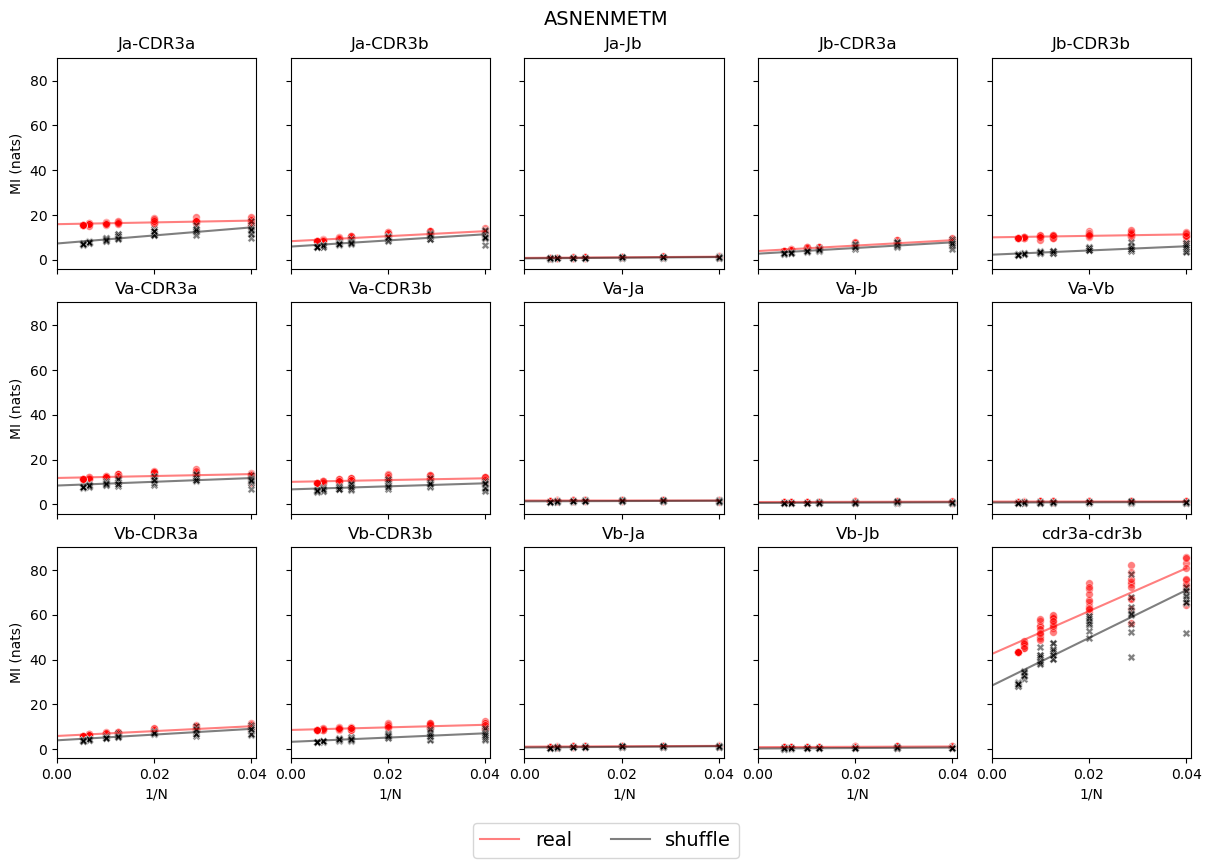

ATDALMTGF


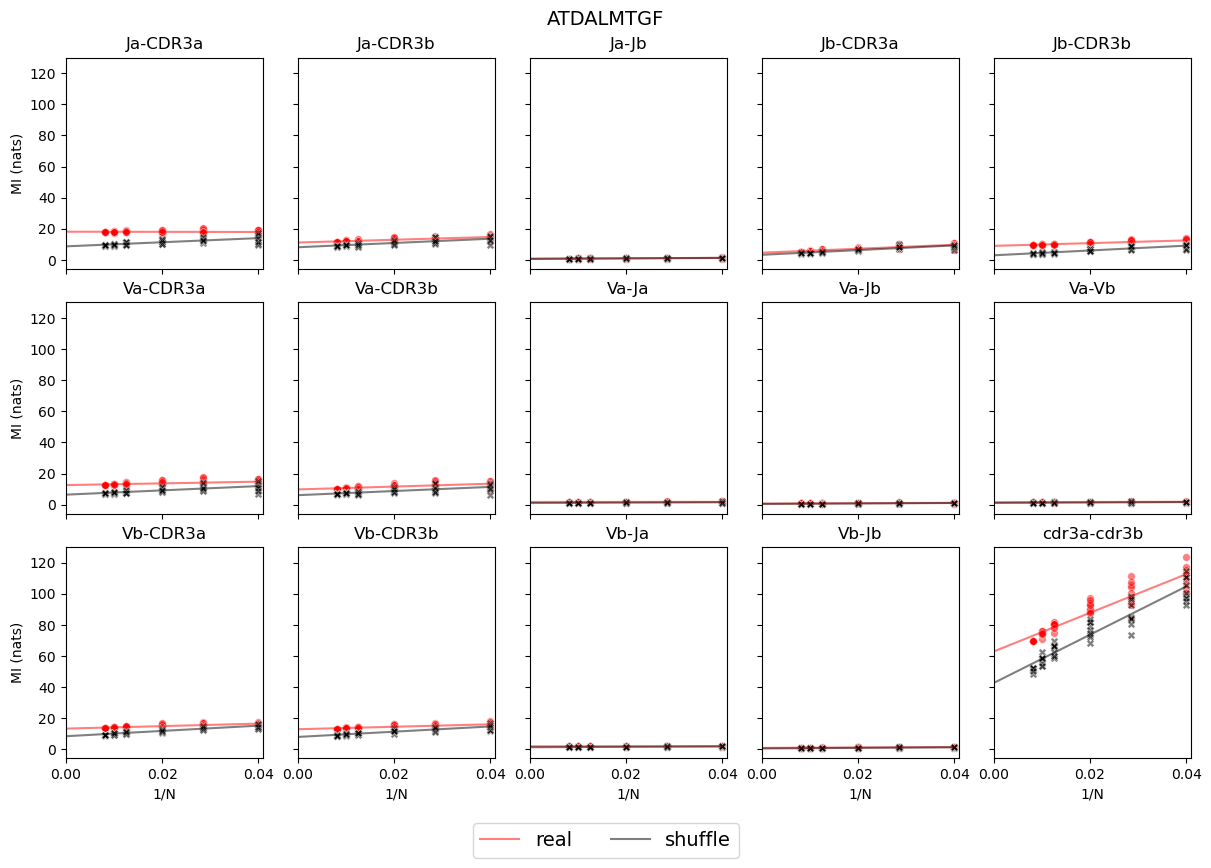

AVFDRKSDAK


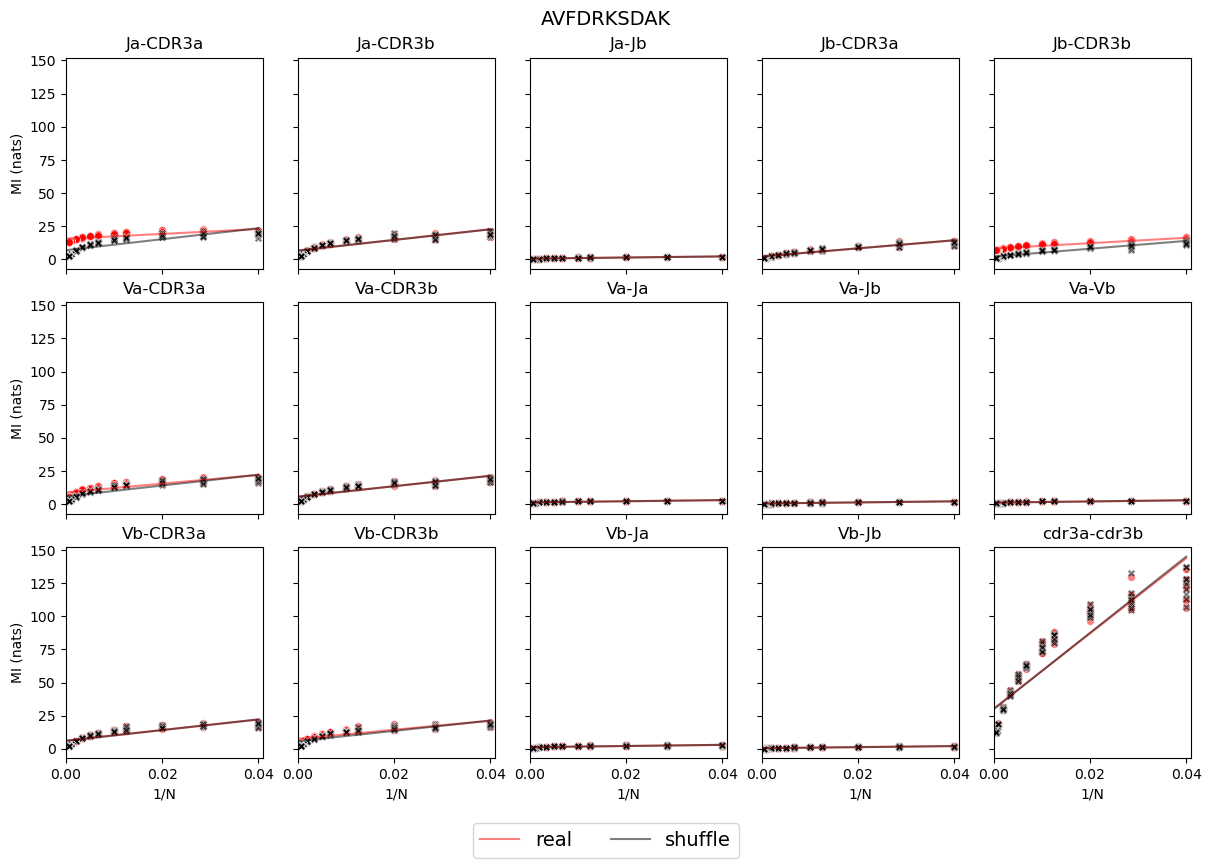

CINGVCWTV


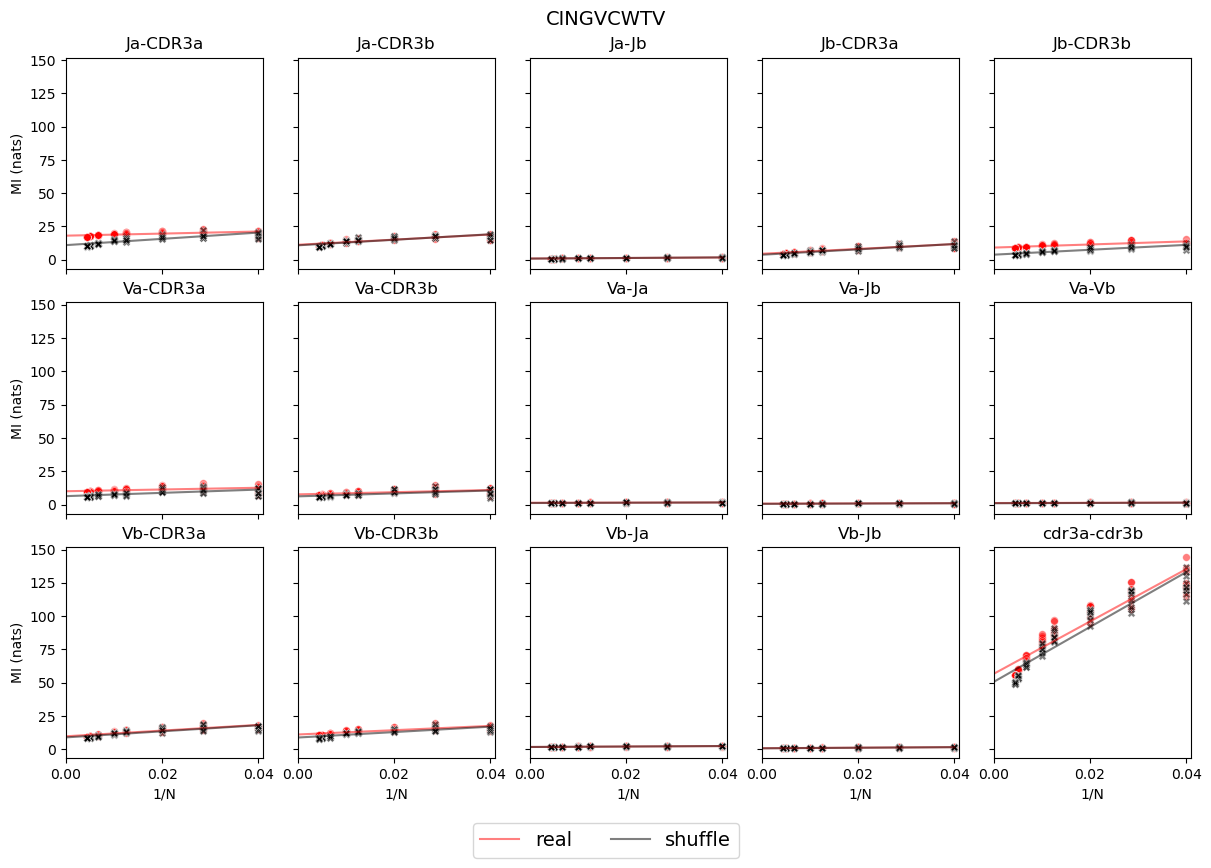

ELAGIGILTV


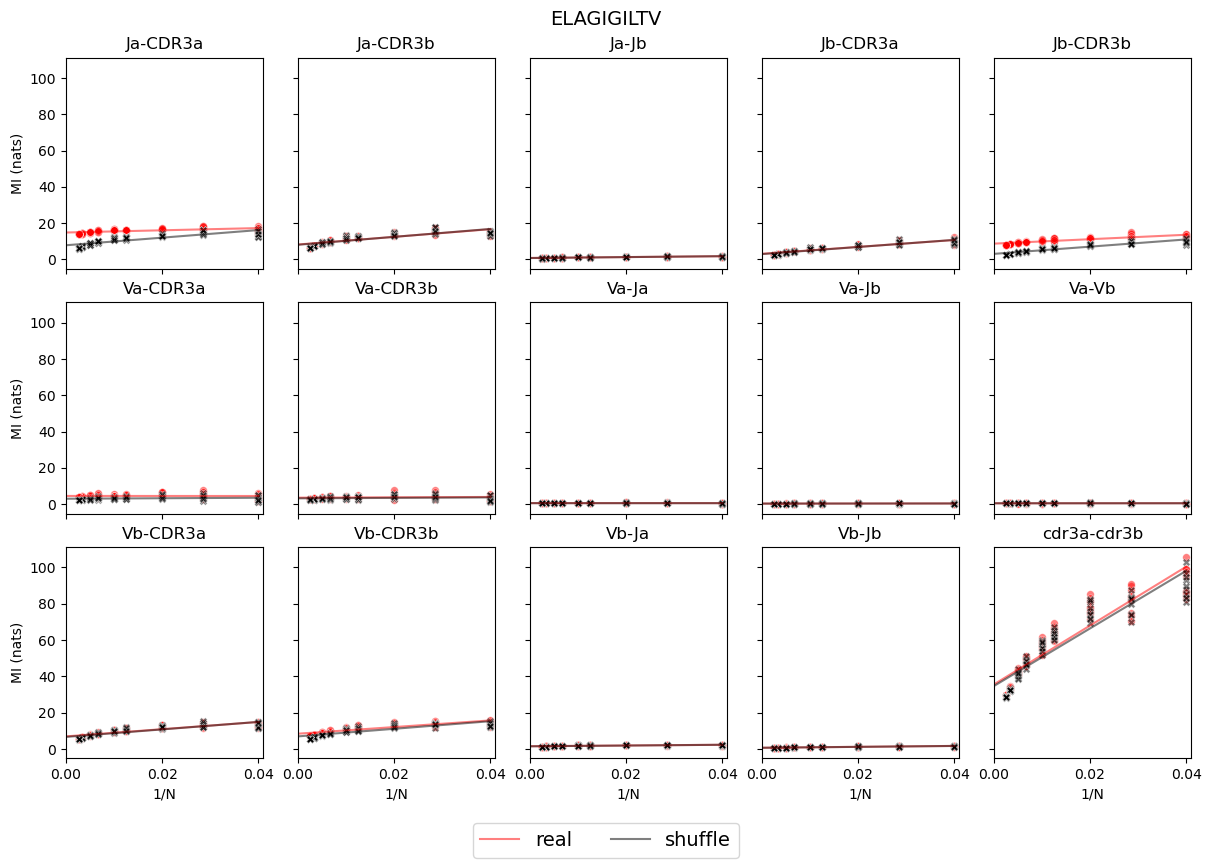

GILGFVFTL


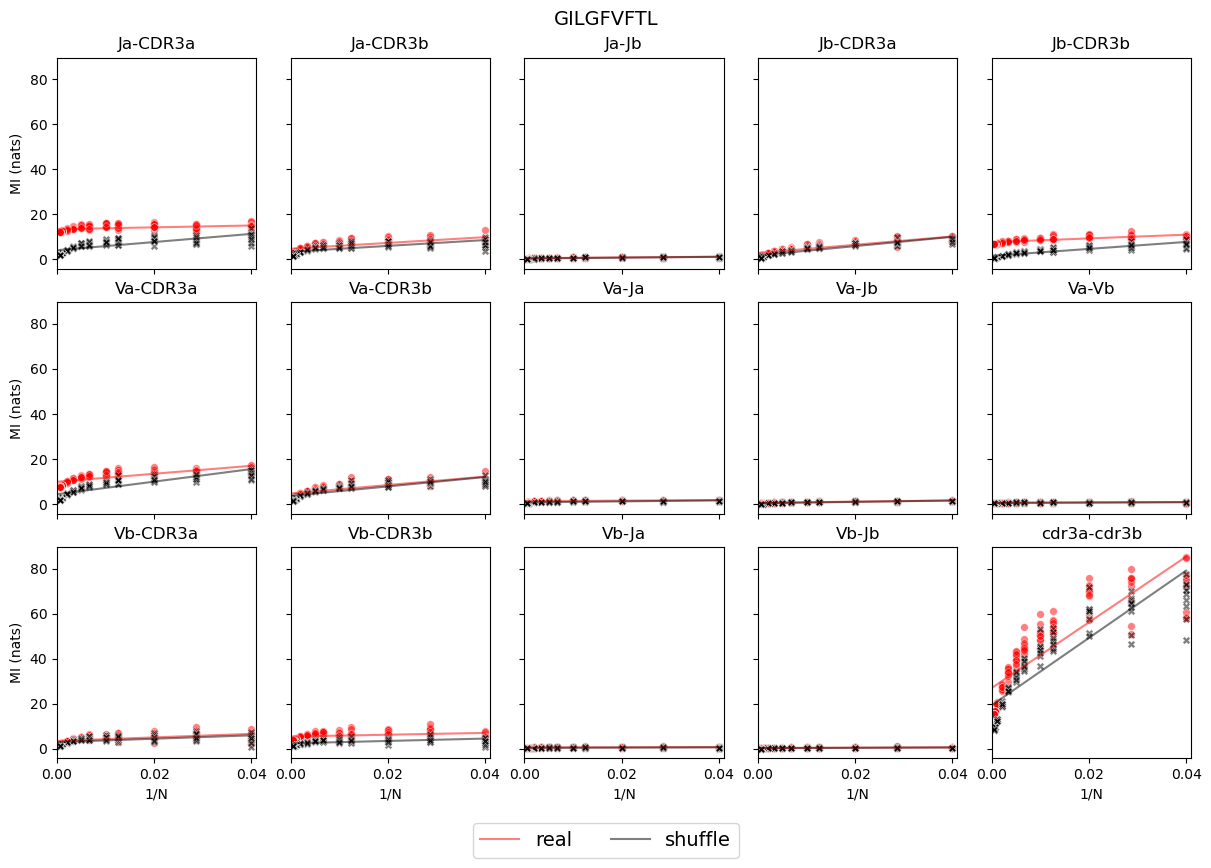

GLCTLVAML


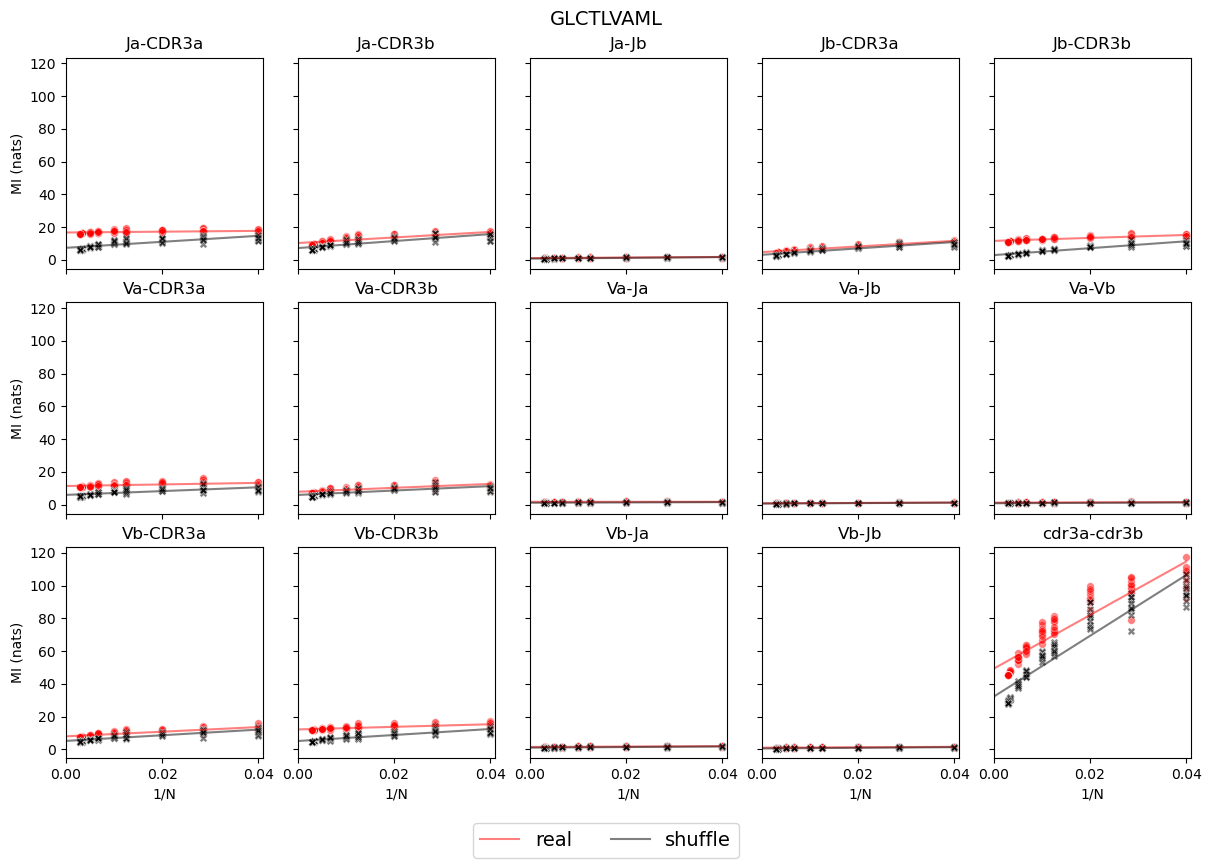

HGIRNASFI


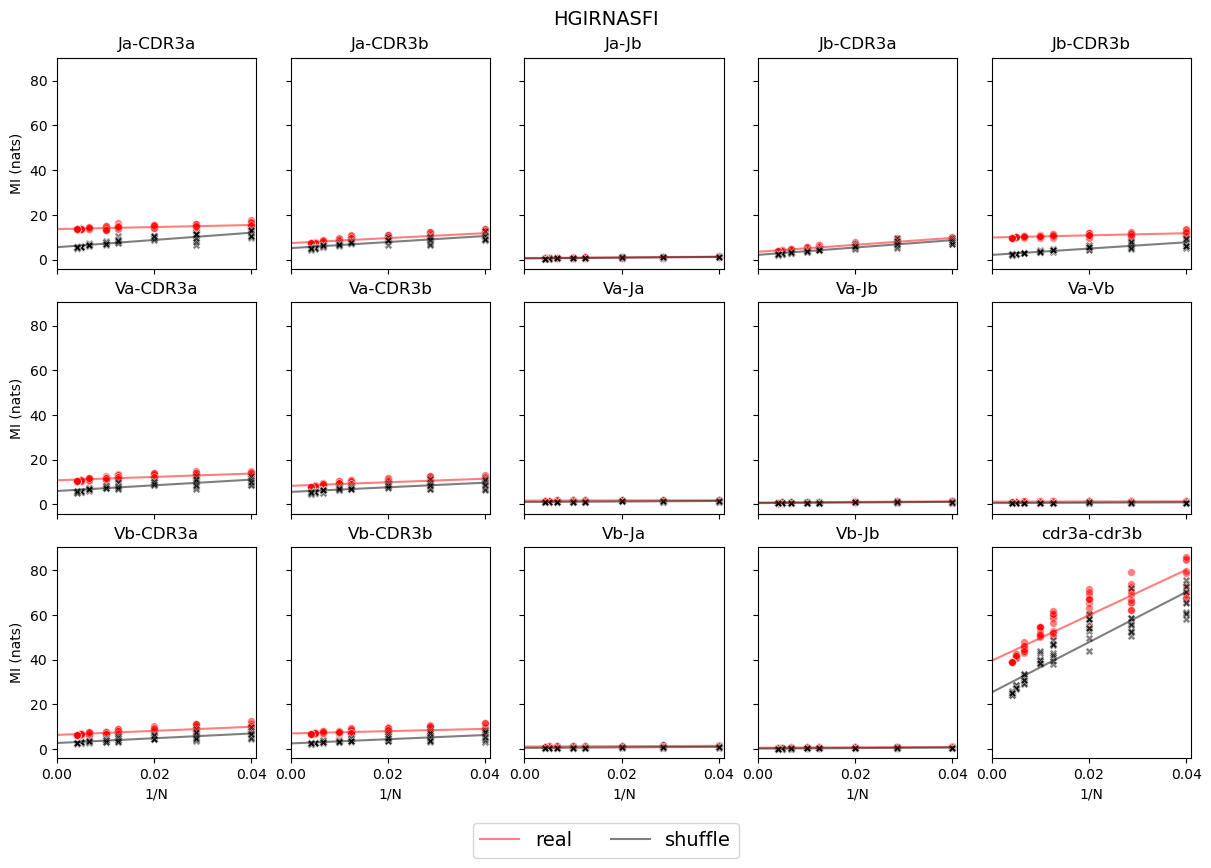

IVTDFSVIK


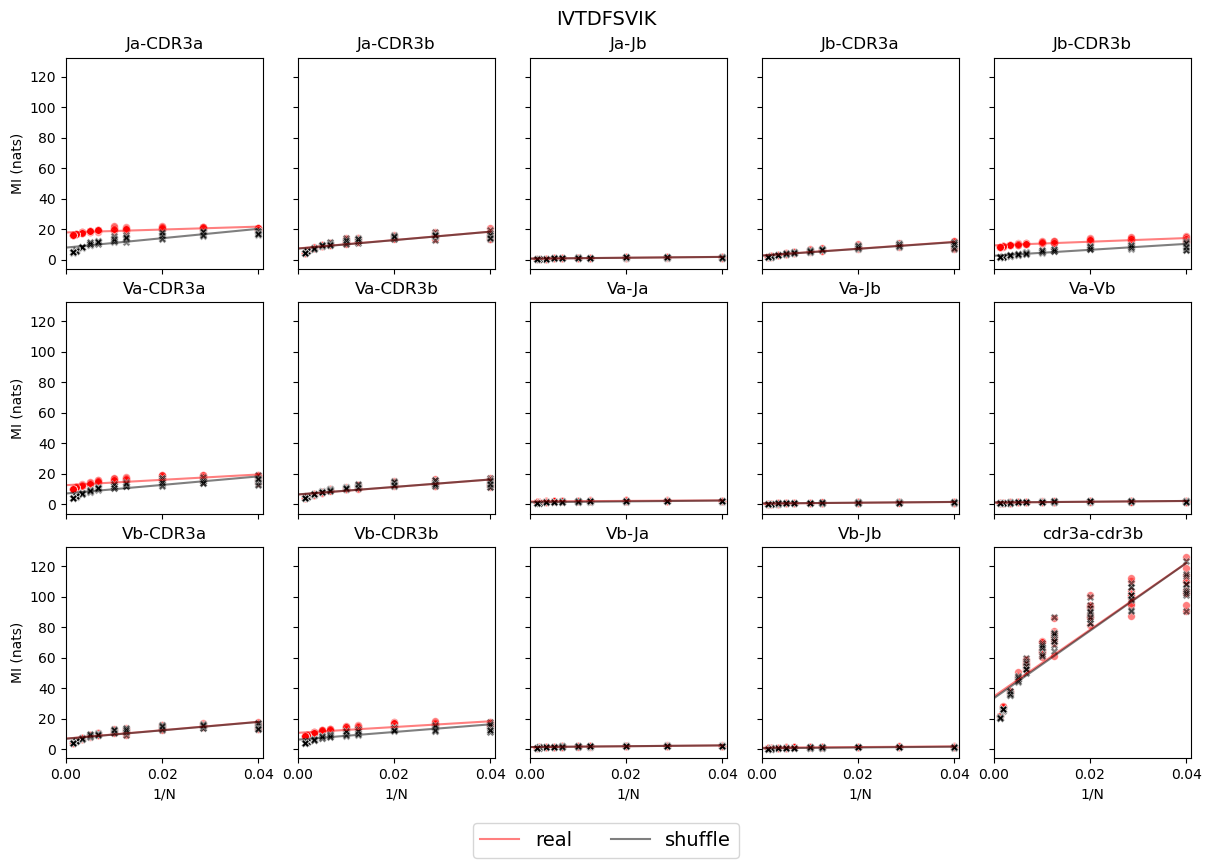

KSKRTPMGF


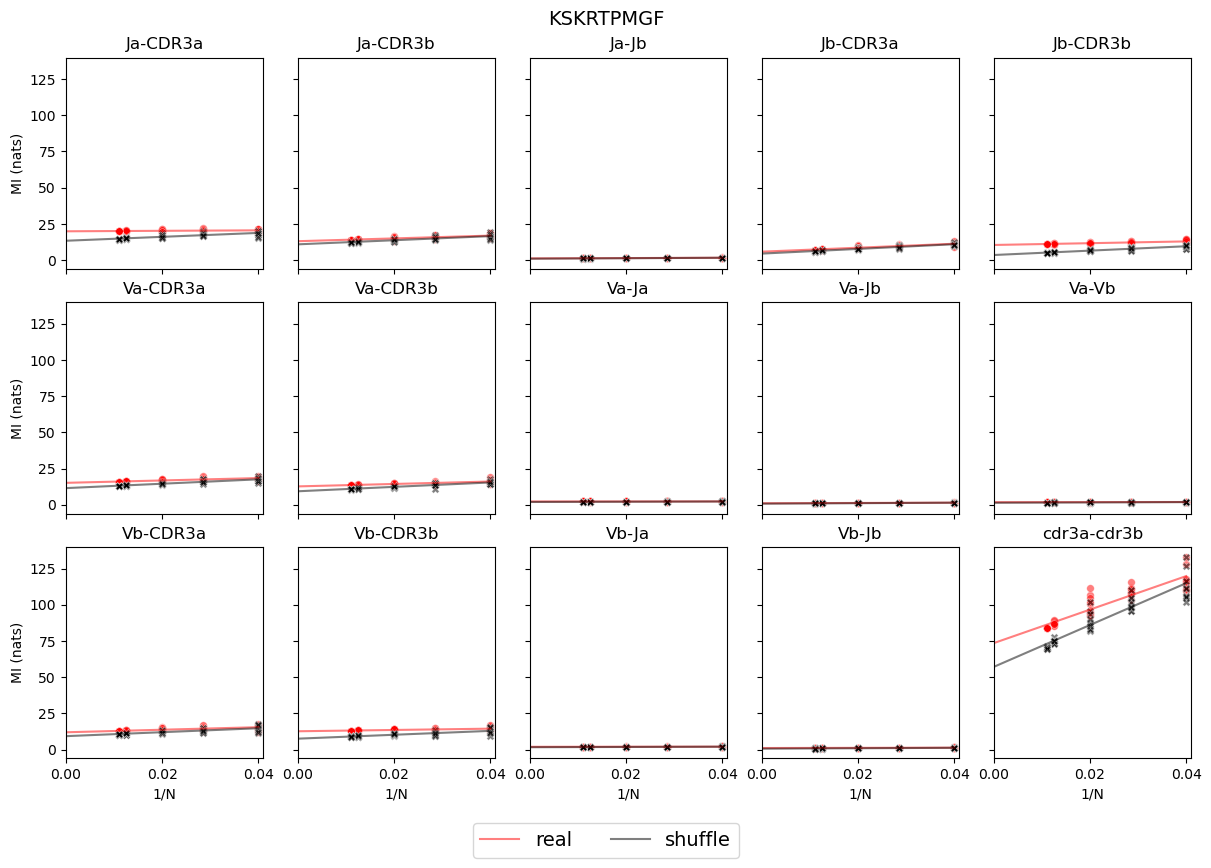

LLWNGPMAV


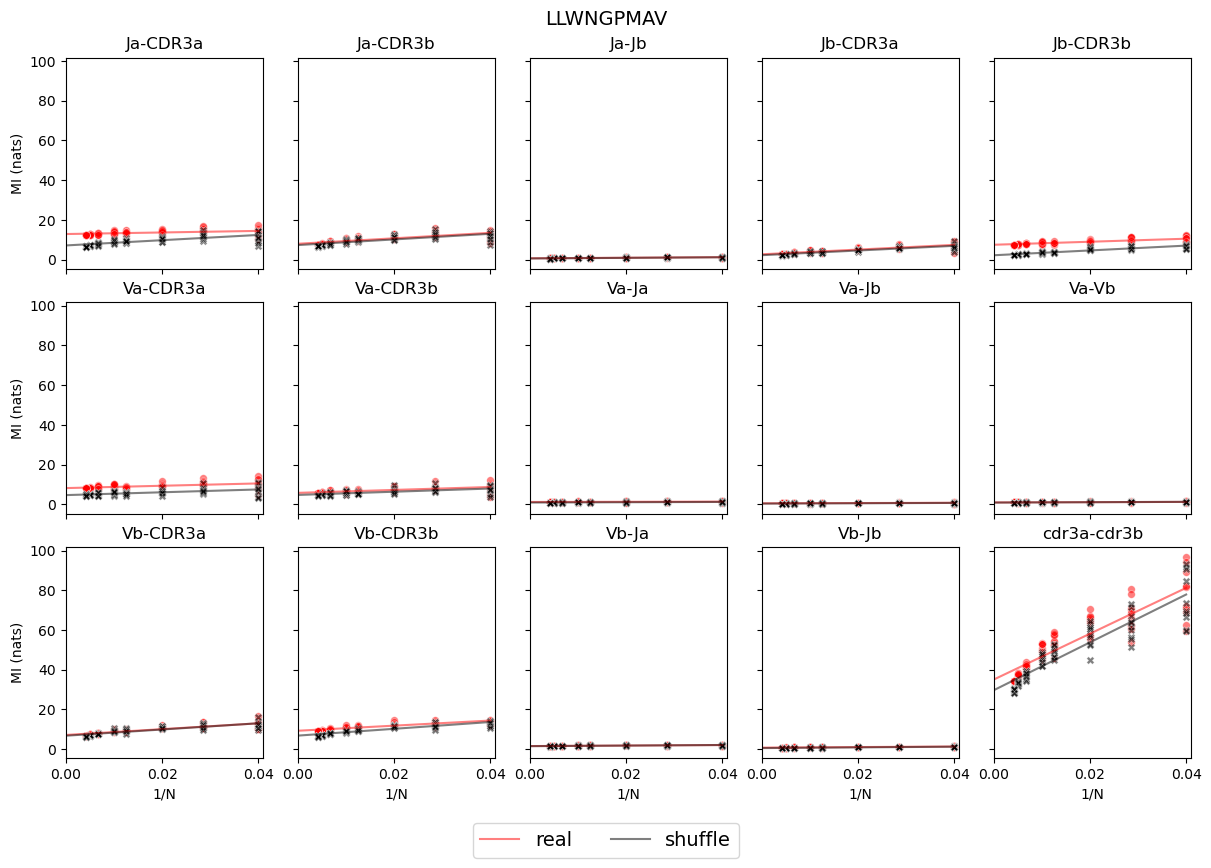

LSLRNPILV


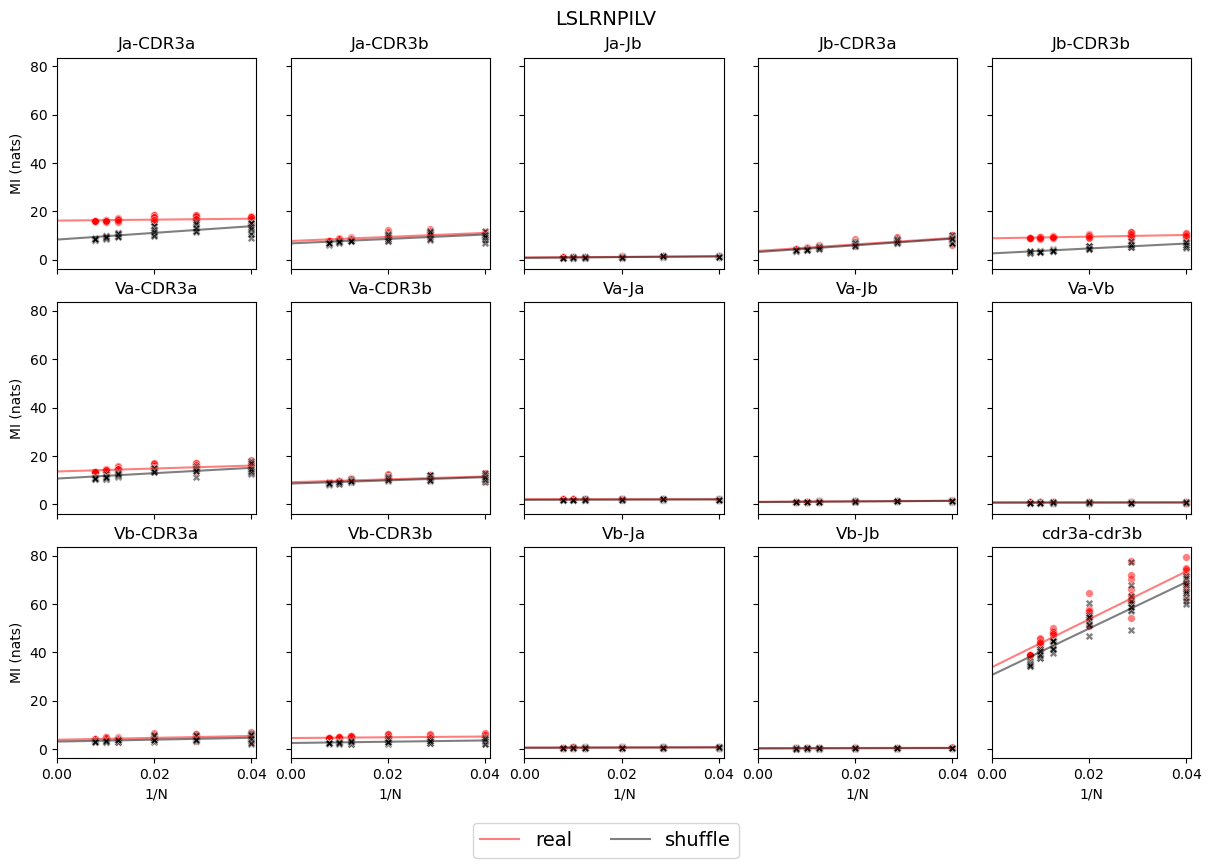

LTDEMIAQY


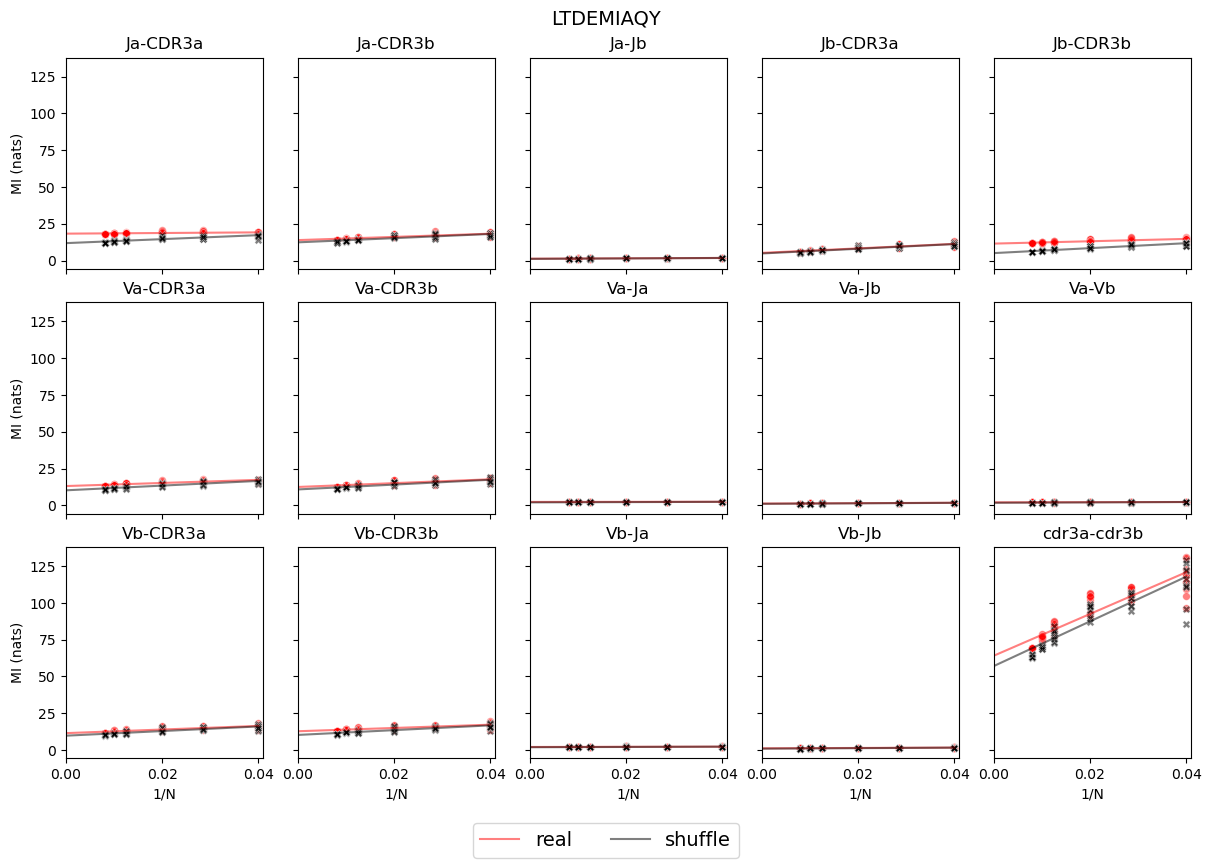

NLVPMVATV


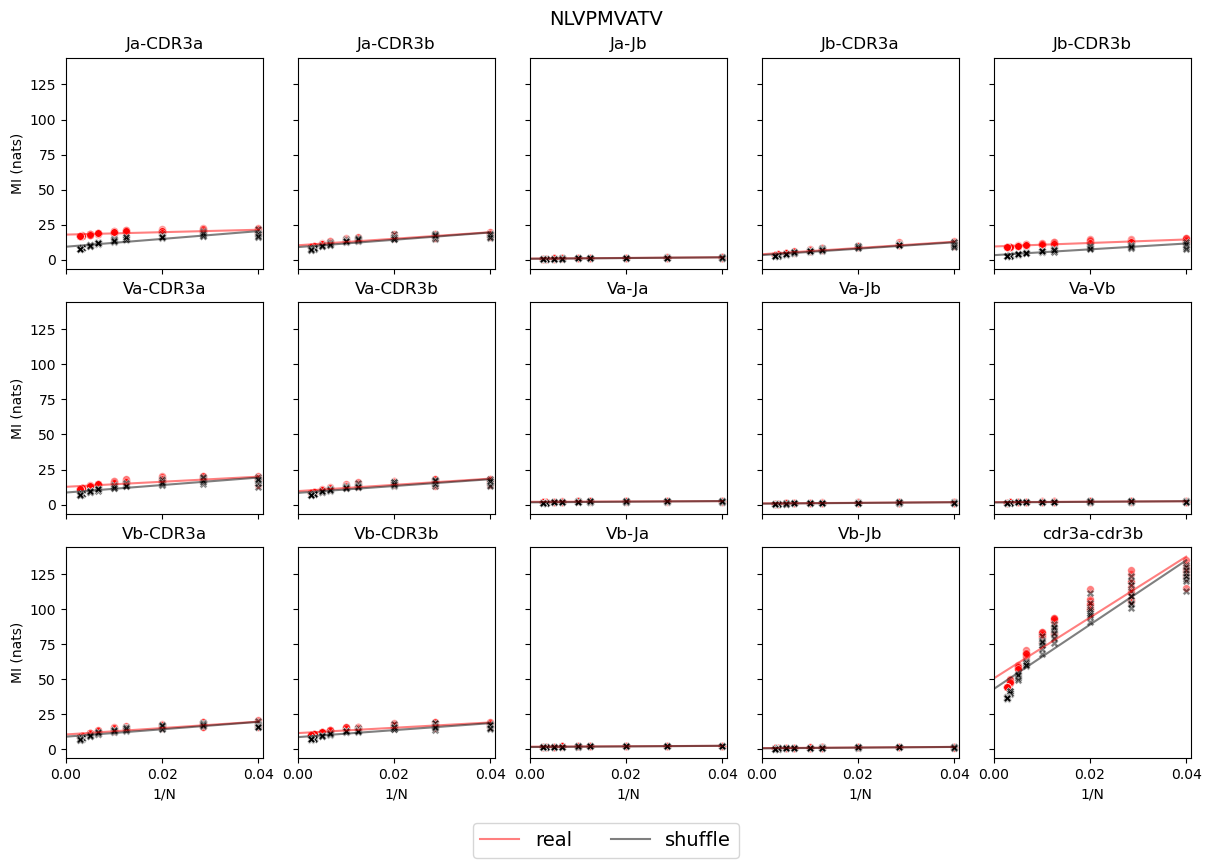

RAKFKQLL


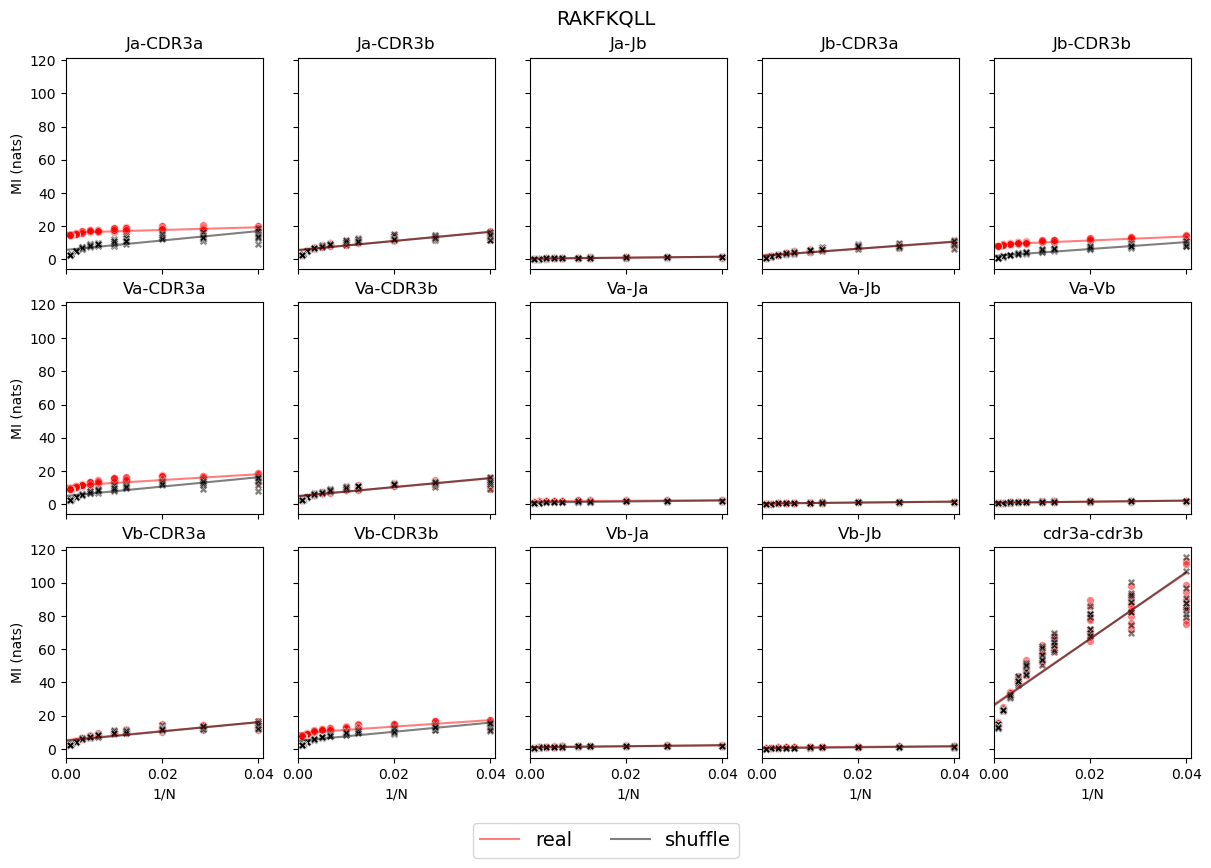

RLRAEAQVK


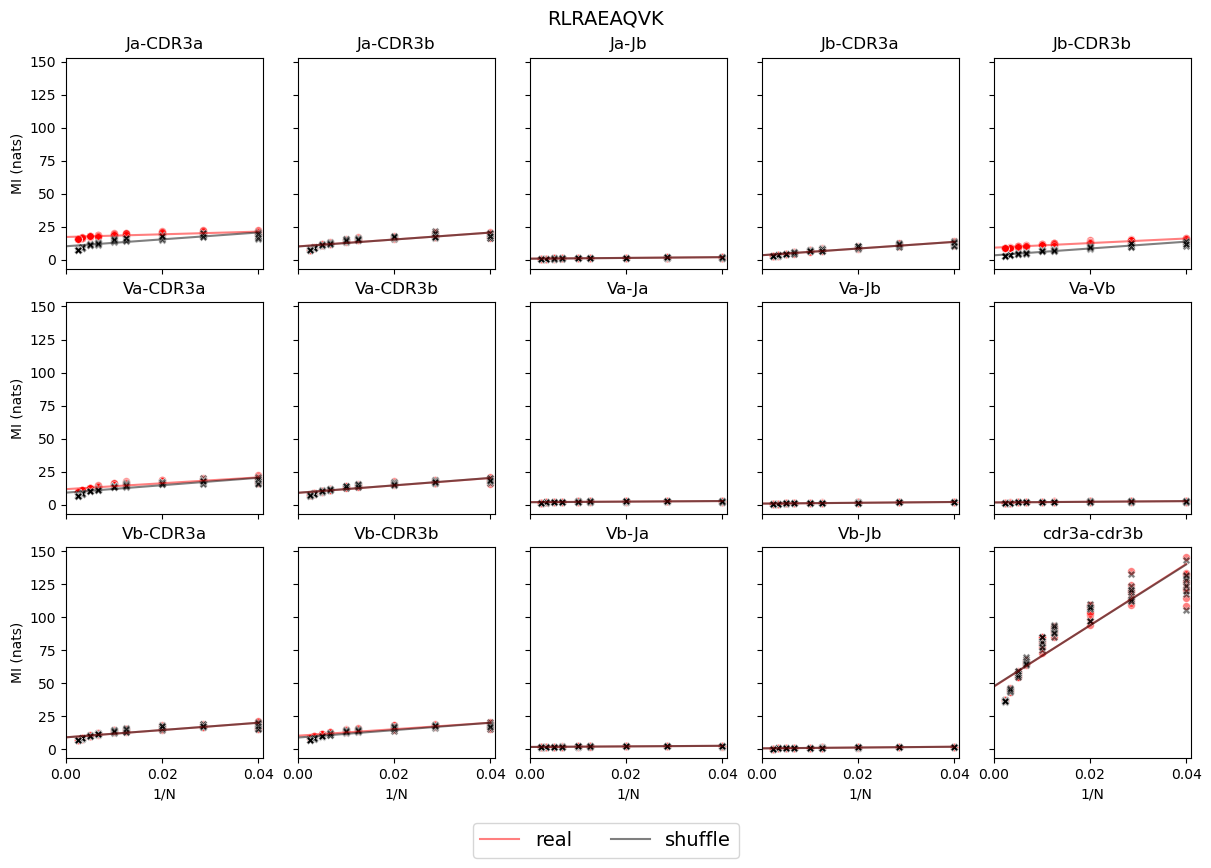

SPRWYFYYL


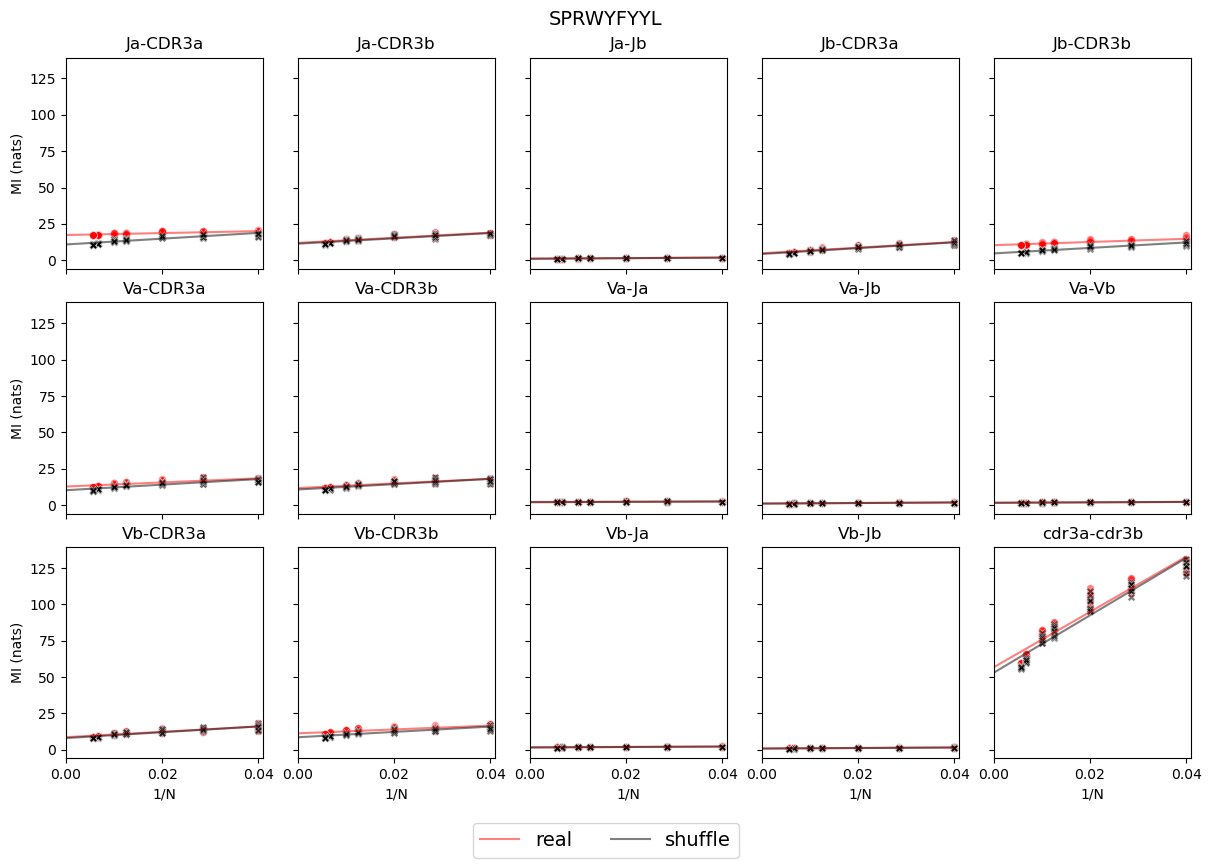

SSLENFRAYV


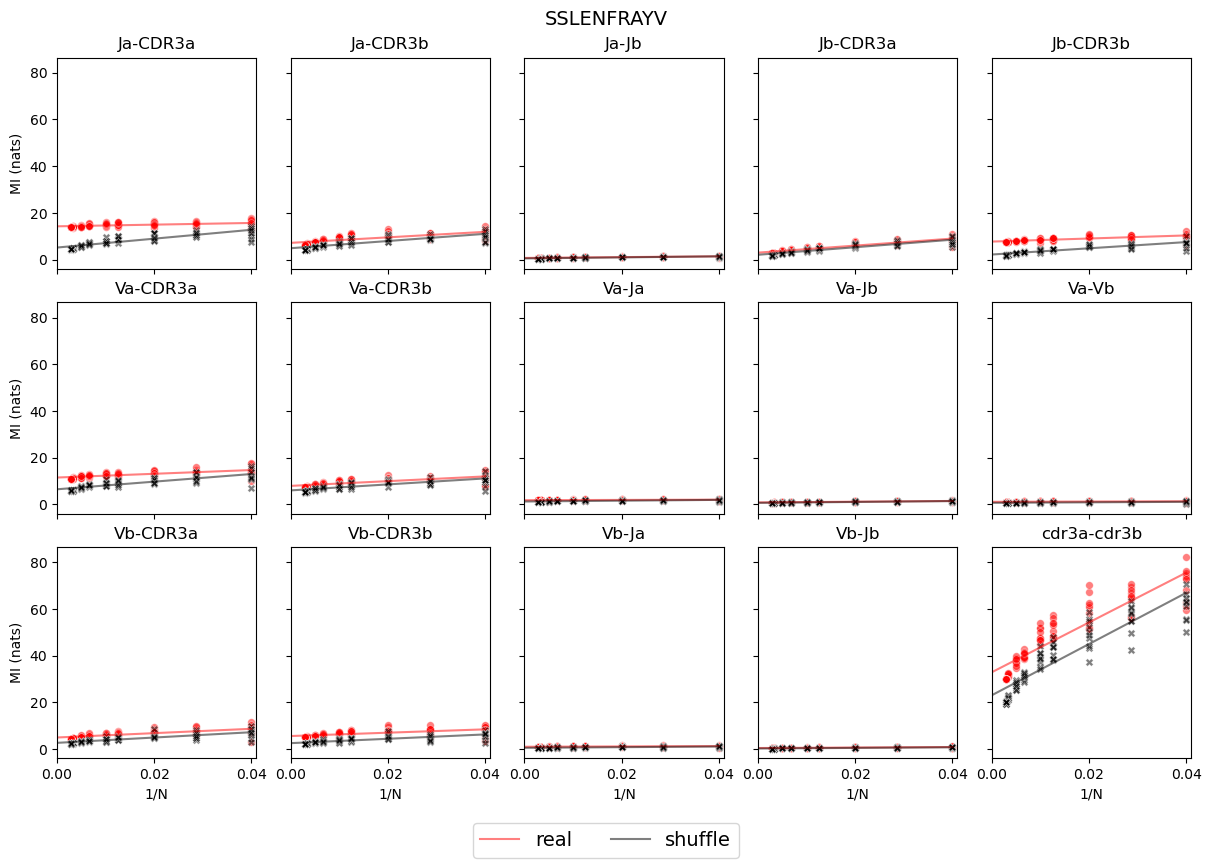

SSPPMFRV


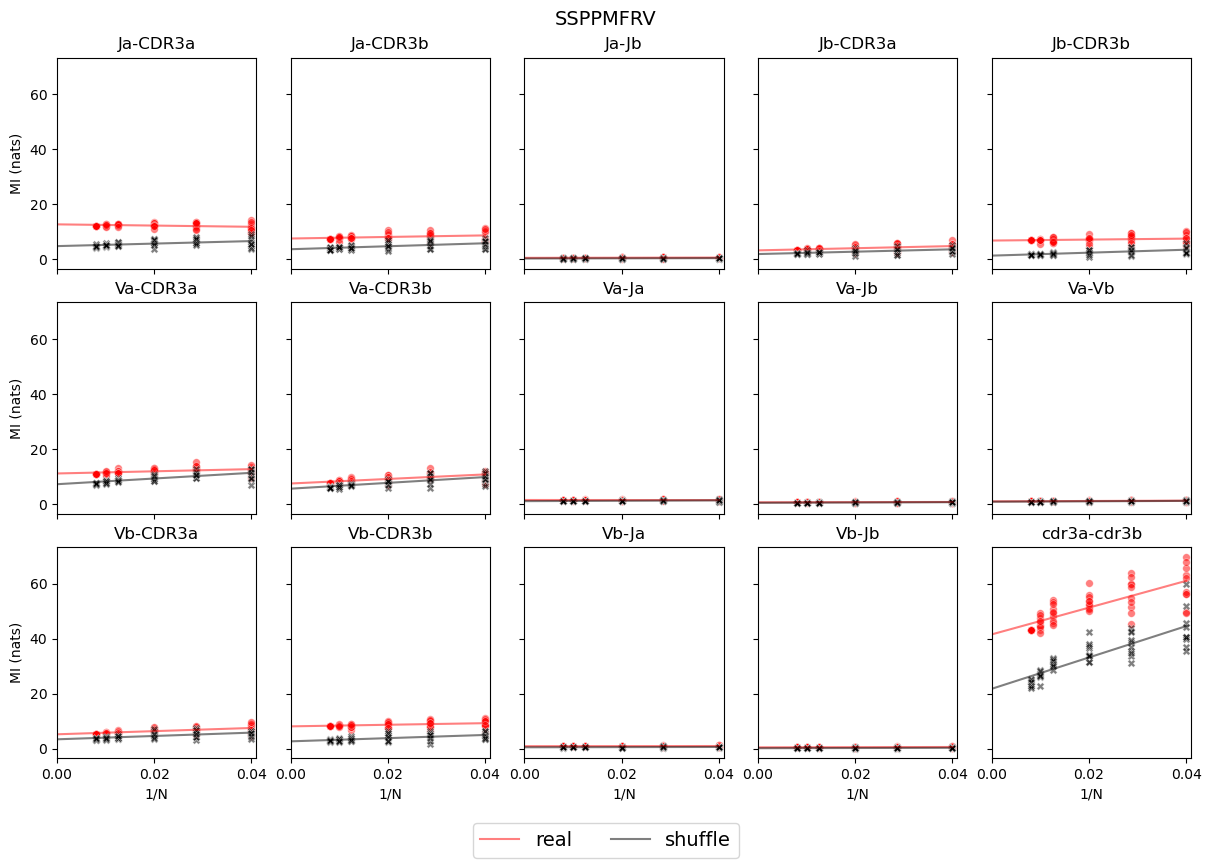

SSYRRPVGI


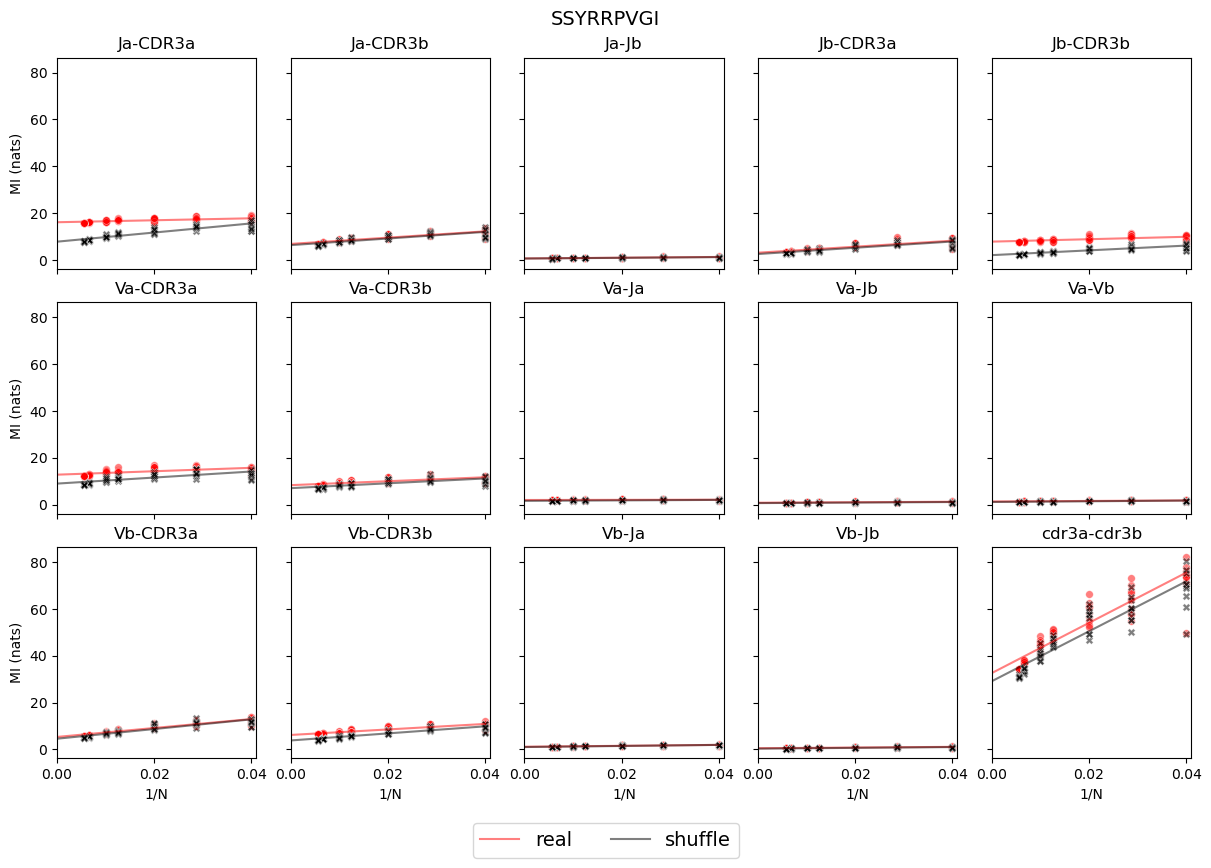

TTDPSFLGRY


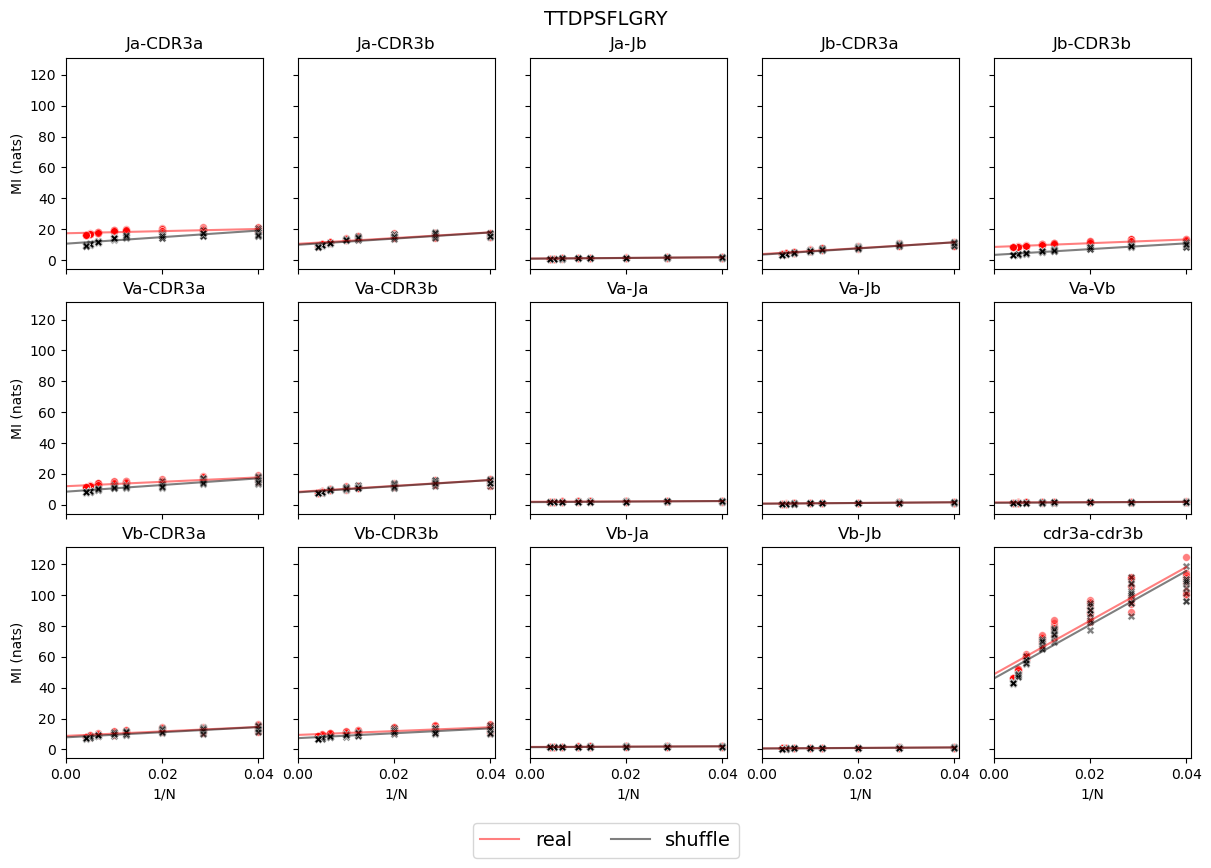

Tanno::A1::naive


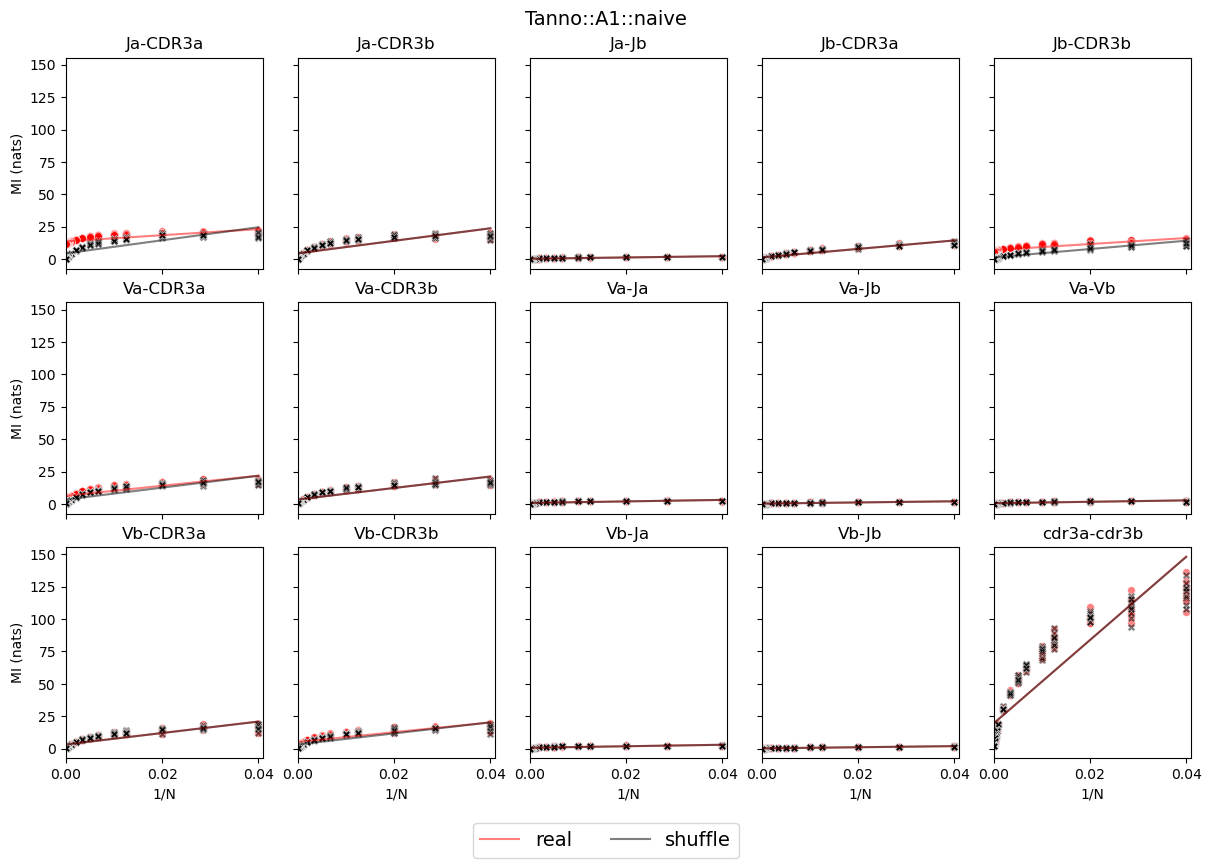

YLQPRTFLL


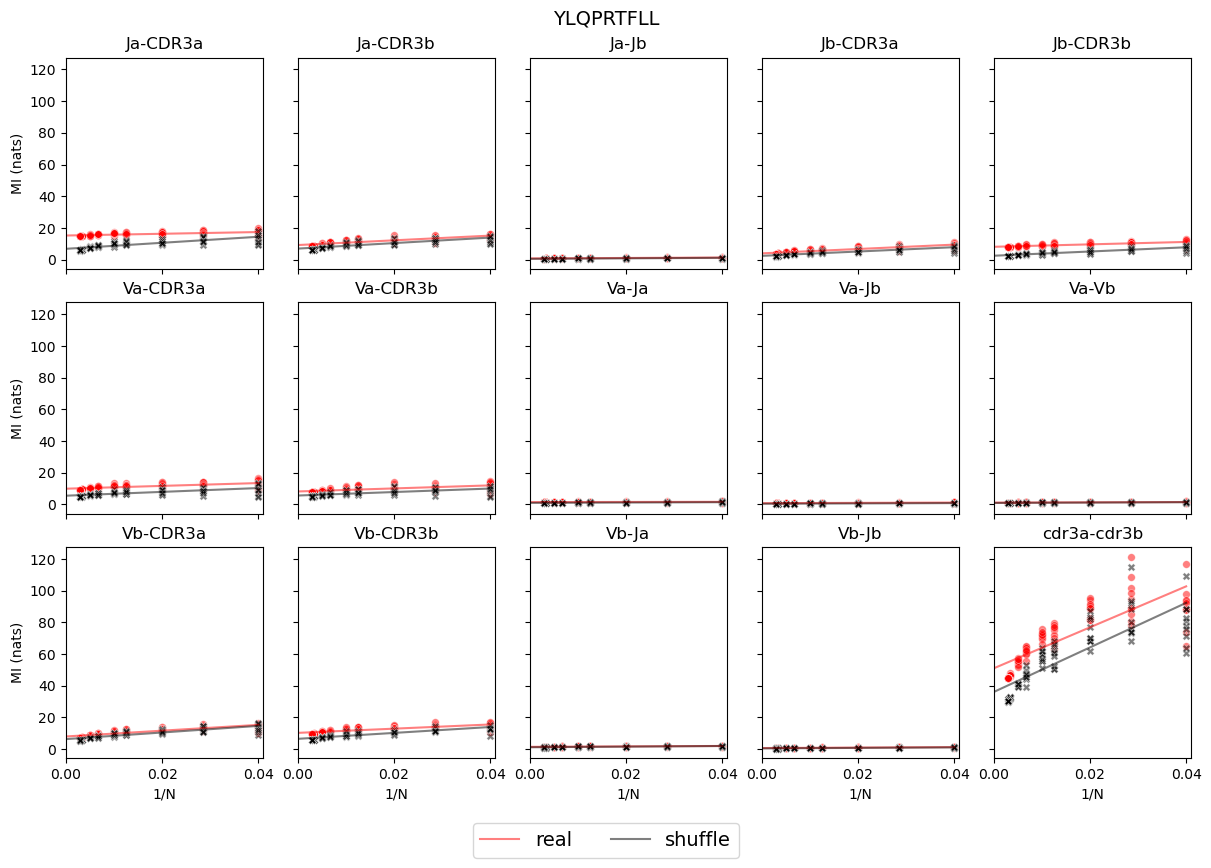

background


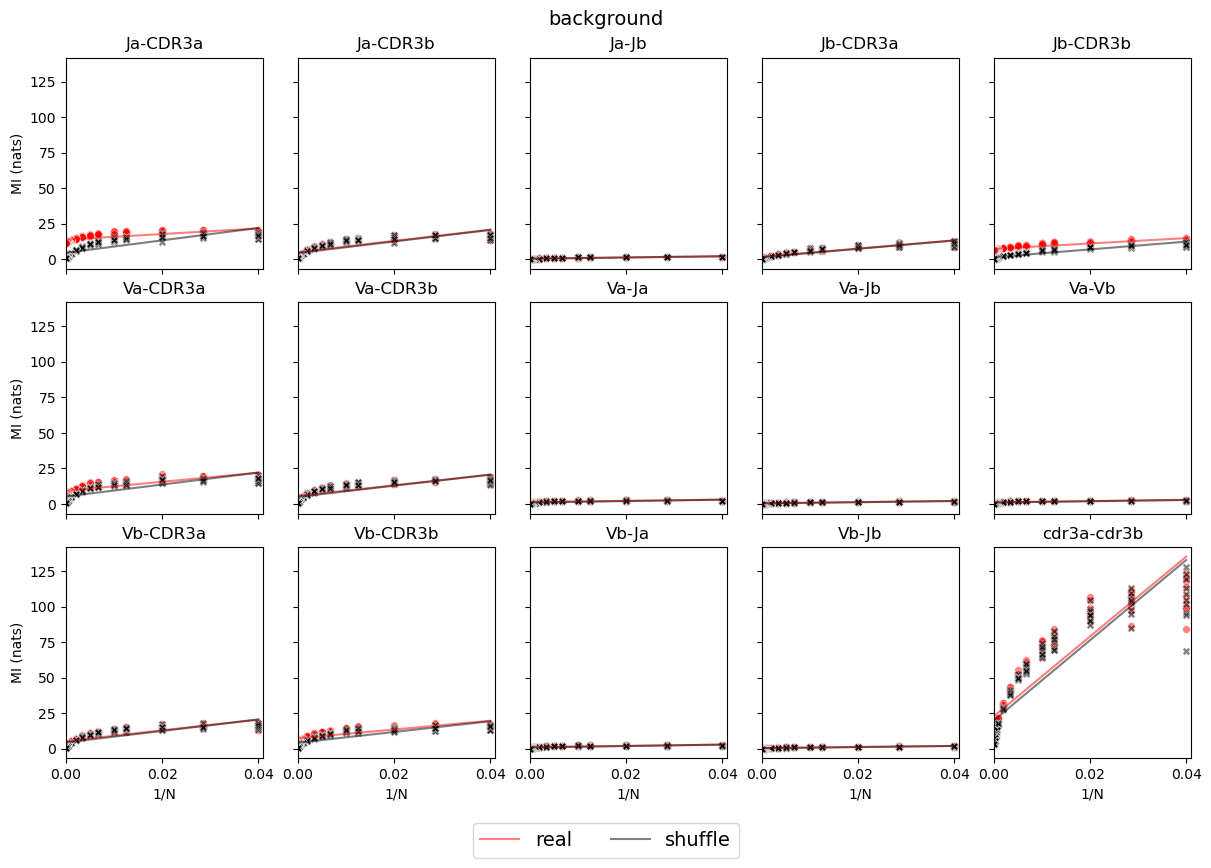

In [14]:
single_val = {}
s = MI2.shape
print(s)
print(MI2['type'].unique().tolist())
MI2_1 = MI2.dropna(subset='type')
print(MI2.shape)
assert s == MI2_1.shape

for ep in sorted(MI2['epitope'].unique().tolist()):
    print(ep)
    f, ax = plt.subplots(ncols=5, nrows=3, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)
    axs = ax.ravel()
    for i, t in enumerate(sorted(MI2['type'].unique().tolist())):
        # print(i, t)
        ss = MI2.loc[(MI2.epitope == ep) & (MI2.type == t)]
        # print(ss.sort_values(by='value', ascending=False))
        single_val[ep + '_' + t] = fit_linear(ss, t, axs[i])
        # print(single_val)
        axs[i].set_ylabel('')
        if i in [0,5,10]:
            axs[i].set_ylabel('MI (nats)')
        if i >= 10:
            axs[i].set_xlabel('1/N')
        
        h, l = axs[i].get_legend_handles_labels()
        axs[i].get_legend().remove()
    lgd = f.legend(handles = h, labels = l,
            bbox_to_anchor=(0.5, -0.01), loc='upper center', 
            ncol=2, prop={'size': 14})
    title = f.suptitle(ep, fontsize=14)
    if ep == 'GLCTLVAML':
        plt.savefig('figures/MI_estimation_GLC.png',
                    bbox_extra_artists=(lgd,title,), bbox_inches='tight')
    plt.show()


In [15]:
MI

25     \
type        Unnamed: 0                                                                    
cdr3a-cdr3b ELAGIGILTV                [98.89605176297307, 98.973567661683, 105.93698...   
            ELAGIGILTV_shuffle        [93.20594724203536, 96.68978381089411, 102.870...   
Va-Vb       ELAGIGILTV                [0.6483915540329324, 0.1887957486295779, 0.418...   
            ELAGIGILTV_shuffle        [0.5929397795881368, 0.1887957486295779, 0.384...   
Ja-Jb       ELAGIGILTV                [1.5130187811670086, 1.4587271681916985, 1.596...   
...                                                                                 ...   
Vb-CDR3a    Tanno::A1::naive_shuffle  [15.683116940910859, 15.925603224786098, 19.06...   
Ja-CDR3b    Tanno::A1::naive          [17.707134513095745, 18.656092282918312, 15.82...   
            Tanno::A1::naive_shuffle  [18.03984515976452, 19.044254704031882, 15.612...   
Jb-CDR3a    Tanno::A1::naive          [12.096178703853987, 11.228795992047978, 13.60...   
            Tanno::A1::naive_shuffle  [12.491679127774505, 11.366883386824833, 13.92...   

                                                                                  35     \
type        Unnamed: 0                                                                    
cdr3a-cdr3b ELAGIGILTV                [83.66822794318261, 81.95784004980058, 75.0229...   
            ELAGIGILTV_shuffle        [83.35738848117147, 83.43289002272309, 74.5061...   
Va-Vb       ELAGIGILTV                [0.3384551930229678, 0.7056865701326933, 0.656...   
            ELAGIGILTV_shuffle        [0.3703328432107121, 0.6810281067796836, 0.385...   
Ja-Jb       ELAGIGILTV                [1.7520038748868394, 1.3957496675298873, 1.591...   
...                                                                                 ...   
Vb-CDR3a    Tanno::A1::naive_shuffle  [15.754678241231813, 18.300944929371838, 15.60...   
Ja-CDR3b    Tanno::A1::naive          [17.130483347648973, 15.867496191069431, 19.52...   
            Tanno::A1::naive_shuffle  [17.21494159886079, 16.283771671787637, 19.999...   
Jb-CDR3a    Tanno::A1::naive          [11.109964687306892, 10.276486696473846, 11.41...   
            Tanno::A1::naive_shuffle  [11.538755127435664, 10.725557559233202, 10.71...   

                                                                                  50     \
type        Unnamed: 0                                                                    
cdr3a-cdr3b ELAGIGILTV                [78.03923420775655, 85.1615628242491, 83.15544...   
            ELAGIGILTV_shuffle        [75.85061615495715, 82.79607371305681, 80.9603...   
Va-Vb       ELAGIGILTV                [0.65219667731499, 0.6735728504050058, 0.35089...   
            ELAGIGILTV_shuffle        [0.7367587683630222, 0.5799302258625213, 0.342...   
Ja-Jb       ELAGIGILTV                [1.4737058089994426, 1.5190484333923362, 1.400...   
...                                                                                 ...   
Vb-CDR3a    Tanno::A1::naive_shuffle  [14.400041945761624, 15.839266326937016, 14.58...   
Ja-CDR3b    Tanno::A1::naive          [17.453020390773766, 19.308416260196424, 17.45...   
            Tanno::A1::naive_shuffle  [17.560796979595015, 18.65712893113764, 17.325...   
Jb-CDR3a    Tanno::A1::naive          [10.17360785961009, 9.473805423854424, 9.78834...   
            Tanno::A1::naive_shuffle  [9.929280462991256, 10.199848922873187, 9.2912...   

                                                                                  80     \
type        Unnamed: 0                                                                    
cdr3a-cdr3b ELAGIGILTV                [64.18424871555378, 67.23830507566377, 63.9722...   
            ELAGIGILTV_shuffle        [63.53075812053341, 65.60909886956411, 62.3753...   
Va-Vb       ELAGIGILTV                [0.580705258003033, 0.5952751223960578, 0.5531...   
            ELAGIGILTV_shuffle        [0.5787148113377625, 0.72956018268084

In [16]:
MI = pd.DataFrame(single_val, index = ['real', 'shuffle']).T
MI.to_csv('data/output/mutual_info/estimated_mutual_info_all_epitopes.csv')

In [17]:
# pC = pd.read_csv('data/output/p_coincidence_vdj_tanno.csv', index_col=0)

In [18]:
# df = pd.merge(pC['1']+10**(-6), MI, left_index = True, right_index = True)
# print(df)
# df0 = df.loc[[x for x in df.index if x in epitopes]]
# df1 = df.loc[[x for x in df.index if 'naive' in x]]
# df2 = df.loc[[x for x in df.index if 'memory' in x]]
# df3 = df.loc[[x for x in df.index if (x not in epitopes) and ('naive' not in x) and ('memory' not in x)]]
# plt.scatter(df0['1'], df0['real'], marker = 's', color = 'magenta', alpha = 0.3, label = 'epitope', s = 50)
# plt.scatter(df1['1'], df1['real'], marker = 'v', color = 'blue', alpha = 0.3, label = 'naive', s = 50)
# plt.scatter(df2['1'], df2['real'], marker = '^', color = 'green', alpha = 0.3, label = 'memory', s = 50)
# plt.scatter(df3['1'], df3['real'], marker = 'o', color = 'r', alpha = 0.3, label = 'repertoire', s = 50)
# plt.scatter(df['1'], df['shuffle'], marker = 'P', color = 'k', alpha = 0.7, s = 30)
# plt.xlabel('pc(d=1)')
# plt.ylabel('Mutual information - 10^-6')
# for ep in epitopes:
#     plt.text(s = ep[0:3], x = df.loc[ep]['1'], y = df.loc[ep]['real'])
# plt.loglog()
# plt.legend(loc='lower right')
# plt.show()

In [19]:
# df = pd.merge(pC['1']+10**(-6), MI, left_index = True, right_index = True)
# df0 = df.loc[[x for x in df.index if x in epitopes]]
# df1 = df.loc[[x for x in df.index if 'naive' in x]]
# df2 = df.loc[[x for x in df.index if 'memory' in x]]
# df3 = df.loc[[x for x in df.index if (x not in epitopes) and ('naive' not in x) and ('memory' not in x)]]
# plt.scatter(df3['1'], df3['real']/df3['shuffle'], marker = 'o', color = 'r', alpha = 0.3, label = 'repertoire', s = 50)
# plt.scatter(df0['1'], df0['real']/df0['shuffle'], marker = 's', color = 'magenta', alpha = 0.3, label = 'epitope', s = 50)
# plt.scatter(df1['1'], df1['real']/df1['shuffle'], marker = 'v', color = 'blue', alpha = 0.3, label = 'naive', s = 50)
# plt.scatter(df2['1'], df2['real']/df2['shuffle'], marker = '^', color = 'green', alpha = 0.3, label = 'memory', s = 50)
# plt.xlabel('pc(d = 1)')
# plt.ylabel('Mutual information - 10^-6, real/shuffle')
# for ep in epitopes:
#     plt.text(s = ep[0:3], x = df.loc[ep]['1'], y = df.loc[ep]['real']/df.loc[ep]['shuffle'])
# plt.axhline(1, c='k', ls=':')
# plt.semilogx()
# plt.legend(bbox_to_anchor = [1.01, 1], loc = 'upper left')
# plt.show()

In [20]:
# df = pd.merge(epitope_counts, MI, left_index = True, right_index = True)
# print(df)
# plt.scatter(df['Epitope'], df['real']/df['shuffle'], marker = 's', color = 'magenta', alpha = 0.3, s = 50)
# plt.axhline(y=1, ls = ':', c = 'k')
# plt.xlabel('Dataset size')
# plt.ylabel('Mutual information - 10^-6, real/shuffle')
# for ep in epitopes:
#     plt.text(s = ep[0:3], x = df.loc[ep]['Epitope'], y = df.loc[ep]['real']/df.loc[ep]['shuffle'])
# plt.semilogx()
# plt.show()

In [21]:
# df = pd.merge(epitope_counts, pC+10**(-3), left_index = True, right_index = True)
# print(df)
# plt.scatter(df['Epitope'], df['1'], marker = 's', color = 'magenta', alpha = 0.3, s = 50)
# plt.axhline(y=0, ls = ':', c = 'k')
# plt.xlabel('Dataset size')
# plt.ylabel('pc(d = 1)')
# for ep in epitopes:
#     plt.text(s = ep[0:3], x = df.loc[ep]['Epitope'], y = df.loc[ep]['1'])
# plt.loglog()
# plt.show()